# Convolution Function

In [11]:
"""
Question (a)

Implement your own conv functions which performs convolution operation without using any neural network packages.
Make sure to handle all possible edge cases to receive full credits.
Keep in mind that height and width of the given image or filter are not always the same.
"""

import numpy as np


def convolution_naive(image, filter, stride=1, padding=0):
    """Performs 2D convolution operation with "4 nested for-loops".

    Args:
    - image: 2D numpy array
    - filter: 2D numpy array
    - stride, padding: integers

    Returns:
    - 2D numpy array : convolution results of the given image and filter.
    - Return None if stride is not compatible. (ex. image of 5*5 with filter 2*2 with stride 2, padding 0)
    - Return None if filter is larger than the given image.
    """

    ##### YOUR CODE #####
    image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode = 'constant', constant_values = 0)
    filter_h, filter_w = filter.shape
    image_h, image_w = image_padded.shape

    output_h = (image_h - filter_h) // stride + 1
    output_w = (image_w - filter_w) // stride + 1

    if output_h <= 0 or output_w <= 0:
      return None

    output = np.zeros((output_h, output_w))

    for i in range(output_h):
      for j in range(output_w):
        act_value = image_padded[i * stride : i * stride + filter_h, j * stride : j * stride + filter_w]
        output[i, j] = np.sum(act_value * filter)
    #####################
    return output


def convolution_vectorized(image, filter, stride=1, padding=0):
    """Performs 2D convolution operation with "less than or equal to 2 nested for-loops".

    Args:
    - image: 2D numpy array
    - filter: 2D numpy array
    - stride, padding: integers

    Returns:
    - 2D numpy array : convolution results of the given image and filter..
    - Return None if stride is not compatible. (ex. image of 5*5 with filter 2*2 with stride 2, padding 0)
    - Return None if filter is larger than the given image.
    """

    ##### YOUR CODE #####
    image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode = 'constant', constant_values = 0)
    filter_h, filter_w = filter.shape
    image_h, image_w = image_padded.shape

    output_h = (image_h - filter_h) // stride + 1
    output_w = (image_w - filter_w) // stride + 1

    if output_h <= 0 or output_w <= 0:
      return None

    output = np.zeros((output_h, output_w))

    indices_h = np.arange(output_h)[:, None] * stride
    indices_w = np.arange(output_w) * stride
    for i in range(filter_h):
      for j in range(filter_w):
        output += image_padded[indices_h + i, indices_w + j] * filter[i, j]
    #####################

    return output

In [12]:
image = np.random.randint(10, size=(256, 256))
filter = np.random.randint(10, size=(16, 16))
stride = 1
padding = 0

print("Compare the time complexity of 2 convolution operations")
print("1. Convolution operation with 4 nested loops")
%timeit -n 3 -r 1 convolution_naive(image, filter, stride, padding)
print("2. Convolution operation with less than or equal to 2 nested loops")
%timeit -n 3 -r 1 convolution_vectorized(image, filter, stride, padding)

Compare the time complexity of 2 convolution operations
1. Convolution operation with 4 nested loops
356 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
2. Convolution operation with less than or equal to 2 nested loops
90 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [13]:
image = np.array([[1, 2, 3, 2, 1], [2, 3, 4, 5, 6], [-1, -2, -3, -4, -5], [0, 0, 1, 0, 0], [7, 1, 7, 1, 7]])
filter = np.array([[1, 0], [0, 1]])
stride = 3
padding = 0

# Expected Result for each convolution functions.
# [[4. 8.]
#  [1. 7.]]
print(convolution_naive(image, filter, stride, padding))
print(convolution_vectorized(image, filter, stride, padding))

[[4. 8.]
 [1. 7.]]
[[4. 8.]
 [1. 7.]]


# Import Modules

In [14]:
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import f1_score

In [ ]:
"""
import modules you need
"""

# Utils

In [15]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this function.
    """
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

In [16]:
def train(model, train_loader, optimizer):
    """
    Trains the model with training data.

    Do NOT modify this function.
    """
    model.train()
    tqdm_bar = tqdm(train_loader)
    for batch_idx, (image, label) in enumerate(tqdm_bar):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))


def evaluate(model, test_loader):
    """
    Evaluates the trained model with test data.

    Do NOT modify this function.
    """
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = []  # Initialize all_labels
    all_predictions = []  # Initialize all_predictions

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            # Store all labels and predictions for F1 score calculation
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return test_loss, test_accuracy, f1

# CIFAR-10 Data Augmentation

In [17]:
def gaussian_smoothing(image, filter_size=3, sigma=1.0):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    center = (filter_size-1)/2
    gaussian_filter = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        for col in range(filter_size):
            gaussian_filter[row, col] = np.exp((-(row-center) ** 2 - (col-center) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)
    image = cv2.filter2D(image, -1, gaussian_filter)
    return image


def color_jitter(image):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return image

In [18]:
def horizontal_flip(image):
    """Flips the image horizontally.

    Question (b)
    - Do not use TorchVision or OpenCV library for this question.
    - You can solve the problem using numpy only.

    Inputs
    - image: an input image of shape (32, 32, 3).

    Returns
    - image: a horizontally-flipped image of shape (32, 32, 3).
    """
    ##### YOUR CODE #####
    image = image[:, ::-1]
    #####################

    return image

100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


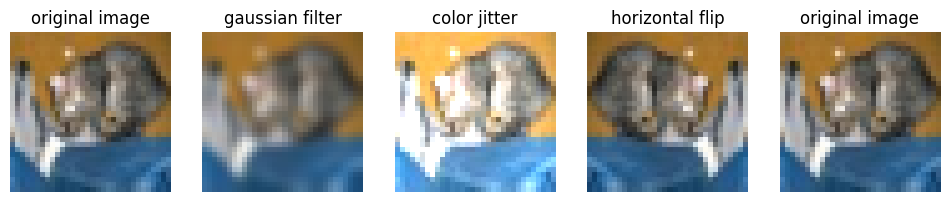

In [19]:
"""
Visualize how the augmentations are applied to a single image.

Do NOT modify.
"""

raw_test = datasets.CIFAR10(root="./CIFAR_10", train=False, download=True)

f, ax = plt.subplots(1, 5)
f.set_size_inches(12, 3)
x = raw_test[0][0]
x = np.array(x)
g = gaussian_smoothing(x)
j = color_jitter(x)
h = horizontal_flip(x)
title = ['original image', 'gaussian filter', 'color jitter', 'horizontal flip', 'original image']
for i, img in enumerate([x, g, j, h, x]):
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(title[i], color='k')

In [20]:
###
# Question (b)
# Briefly explain whether horizontal flip is a good augmentation method for image classification task.
###

horizontal flipping은 유용한 data augmentation 기술 중에 하나이다.
model의 image input에 대한 일반화를 도와주고, 왼쪽, 오른쪽이 바뀌었을 때, image의 대략적인 의미(label)가 바뀌지 않는 다면 image의 개수를 늘리면서 효과적인 augmentation이 가능하다.
다만, 글자나 교통 표지판과 같은 수평 방향으로 의미가 상관 있는 image와 같은 data에서는 효과적인 augmentation이 될 수 없으니 주의할 필요가 있을 것이다.

In [38]:
class CustomDataset(Dataset):
    def __init__(self, train, prob=0.5, data_dir="./CIFAR_10"):
        """
        Do NOT modify this method.
        """
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.prob = prob

    def __len__(self):
        """
        Do NOT modify this method.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Do NOT modify this method.
        """
        return self.data[idx]

    def transform(self, image):
        """
        Apply stochastic data augmentation to the given image.

        Question (c)
        - Convert the given RGB image into BGR scale using opencv library.
        - Apply random augmentation (gaussian smoothing, color jitter, and horizontal flip).
        - Random augmentation is applied with the probability of self.prob.
        - If self.prob = 0.5, 5 out of 10 images will be augmented on average.
        - Convert the augmented image back to RGB scale for training.

        Inputs
        - image: numpy array of an input image of shape (32,32,3).
        Returns
        - image: numpy array of the augmented input image with shape (32,32,3).
        """
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        ##### YOUR CODE #####
        if np.random.rand() < self.prob:
            # Randomly choose one of three augmentations with equal probability
            augment_choice = np.random.rand()

            if augment_choice < 1/3:
                image = gaussian_smoothing(image)
            elif augment_choice < 2/3:
                image = color_jitter(image)
            else:
                image = horizontal_flip(image)
        #####################

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def collate_fn(self, data):
        """
        Creates a batch of images and label tensors.

        Question (d)
        - Convert each image in the batch from PIL image to numpy array.
        - Transform the image using self.transform method to apply random augmentation.
        - Normalize the transformed image by mapping the range [0, 255] to range [0, 1].
        - Transpose the (H * W * C) format of the image into (C * H * W) format.
          - To be specific, the dimension of the original image is (32, 32, 3).
          - We want the dimension of the transposed image to be (3, 32, 32).
        - Convert the batch of preprocessed images into PyTorch float tensors.
        - Convert the batch of labels into PyTorch long tensors.
        - Do NOT use torchvision.transforms library!

        Inputs
        - list of tuples, each containing a PIL image and an integer label
        - number of tuples in the list == BATCH SIZE

        Returns
        - batch of image tensors, batch of label tensors
        - size: (BATCH, CHANNEL, HEIGHT, WIDTH), (BATCH)
        """
        batch_x, batch_y = [], []

        ##### YOUR CODE #####

        for image, label in data:
          image = np.array(image)
          image = self.transform(image)
          image = np.array(image, dtype=np.float32) / 255.0
          image = np.transpose(image, (2, 0, 1))
          batch_x.append(image)
          batch_y.append(label)

        batch_x = torch.tensor(batch_x, dtype=torch.float32)
        batch_y = torch.tensor(batch_y, dtype=torch.long)
        #####################

        return batch_x, batch_y


Files already downloaded and verified


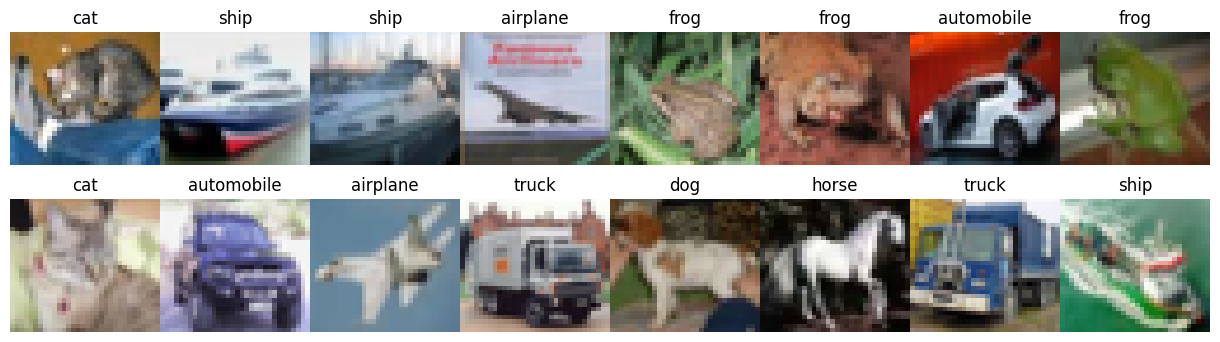

In [39]:
"""
Plot some example images and class labels without applying data augmentation.

Do NOT modify.
"""

raw_test_dataset = CustomDataset(train=False, prob=0, data_dir="./CIFAR_10")
raw_test_loader = DataLoader(dataset=raw_test_dataset, batch_size=16, shuffle=False, collate_fn=raw_test_dataset.collate_fn)

plot_dataset(raw_test_loader)

Files already downloaded and verified
Files already downloaded and verified


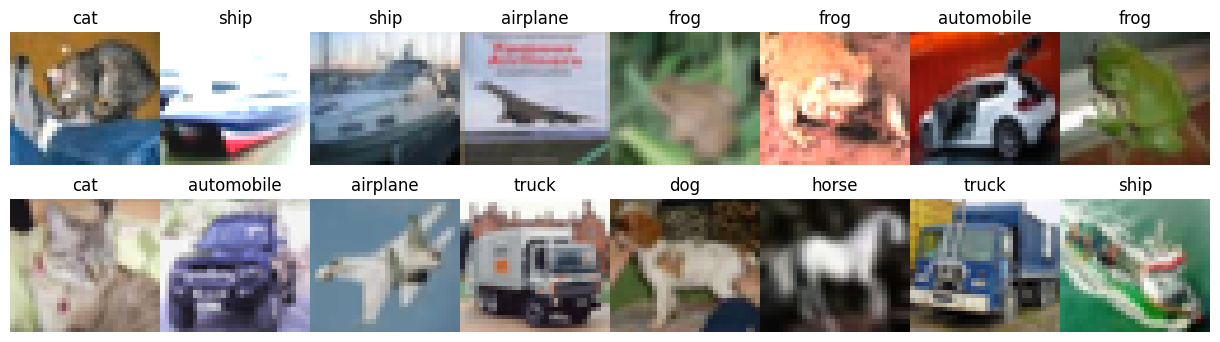

In [40]:
"""
Same examples after applying data augmentation with 50% probability.
If your transform (c) and collate_fn (d) methods have been implemented well, some of the results should look different from the ones above.

Do NOT modify.
"""

train_dataset = CustomDataset(train=True, prob=0.5)
test_dataset = CustomDataset(train=False, prob=0.5)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

plot_dataset(test_loader)

# ConvNet Image Classification

In [ ]:
###
# Question (e)
# Train your ConvNet to achieve test accuracy above 70%
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
###

In [41]:
class ConvNet(nn.Module):
    """
    Builds a ConvNet model.

    Question (e)
    - things that might be useful...
    - stack [Conv2D + Conv2D + MaxPool2D] at least three times,
    - follwed by at least three Linear layers.
    - 3x3 filter is enough, but feel free to use larger filter size.
    - channels used: [10, 32, 64, 128, 256, 512, 1024]
    - you can choose smaller or larger channel size as well.
    - The model may include BatchNormalization, regularizers, and Dropout, but they are not necessary.
    """
    def __init__(self):
        """
        Define the layers that you would like to use in your model.
        """
        super(ConvNet, self).__init__()

        ##### YOUR CODE #####
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(10, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        #####################

    def forward(self, x):
        """
        Apply forward pass of the given batch of input images.
        Inputs
        - x: batch of input images.
        Returns
        - softmax probabilites of the input image for each class label
        """

        ##### YOUR CODE #####
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim = 1)
        #####################

        return x

In [42]:
"""
Make sure your runtime type is GPU and you are using PyTorch version higher than 1.8!

Do NOT modify.
"""

DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 2.5.1+cu124, Device: cuda


In [43]:
"""
Load your customized model "ConvNet" and its training settings.
You may choose the number of epochs that you would like to train.
You might want to use different optimizers or learning rates.
"""

EPOCHS = 20
model = ConvNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print(model)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_featur

In [44]:
"""
Train your model "ConvNet" with the augmented CIFAR-10 dataset.
Upon successful training, test accuracy of your model should be above 70%.

Do NOT modify.
"""

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy, test_f1_score = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: ConvNet, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}, \tTest F1_Score: {:.4f} % \n".format(
        epoch, test_loss, test_accuracy, test_f1_score))

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: ConvNet, 	Test Loss: 0.0252, 	Test Accuracy: 40.61, 	Test F1_Score: 0.3849 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: ConvNet, 	Test Loss: 0.0207, 	Test Accuracy: 51.96, 	Test F1_Score: 0.5206 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: ConvNet, 	Test Loss: 0.0176, 	Test Accuracy: 60.62, 	Test F1_Score: 0.6111 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: ConvNet, 	Test Loss: 0.0170, 	Test Accuracy: 61.75, 	Test F1_Score: 0.6116 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: ConvNet, 	Test Loss: 0.0157, 	Test Accuracy: 65.17, 	Test F1_Score: 0.6449 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: ConvNet, 	Test Loss: 0.0133, 	Test Accuracy: 70.30, 	Test F1_Score: 0.7033 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: ConvNet, 	Test Loss: 0.0127, 	Test Accuracy: 72.56, 	Test F1_Score: 0.7237 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: ConvNet, 	Test Loss: 0.0127, 	Test Accuracy: 71.80, 	Test F1_Score: 0.7186 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: ConvNet, 	Test Loss: 0.0118, 	Test Accuracy: 73.52, 	Test F1_Score: 0.7344 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: ConvNet, 	Test Loss: 0.0119, 	Test Accuracy: 74.52, 	Test F1_Score: 0.7422 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 11], 	Model: ConvNet, 	Test Loss: 0.0115, 	Test Accuracy: 74.91, 	Test F1_Score: 0.7500 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 12], 	Model: ConvNet, 	Test Loss: 0.0117, 	Test Accuracy: 75.79, 	Test F1_Score: 0.7559 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 13], 	Model: ConvNet, 	Test Loss: 0.0120, 	Test Accuracy: 74.84, 	Test F1_Score: 0.7494 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 14], 	Model: ConvNet, 	Test Loss: 0.0125, 	Test Accuracy: 74.65, 	Test F1_Score: 0.7434 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 15], 	Model: ConvNet, 	Test Loss: 0.0121, 	Test Accuracy: 76.14, 	Test F1_Score: 0.7614 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 16], 	Model: ConvNet, 	Test Loss: 0.0120, 	Test Accuracy: 76.17, 	Test F1_Score: 0.7625 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 17], 	Model: ConvNet, 	Test Loss: 0.0123, 	Test Accuracy: 76.25, 	Test F1_Score: 0.7583 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 18], 	Model: ConvNet, 	Test Loss: 0.0119, 	Test Accuracy: 77.08, 	Test F1_Score: 0.7686 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 19], 	Model: ConvNet, 	Test Loss: 0.0125, 	Test Accuracy: 76.30, 	Test F1_Score: 0.7616 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 20], 	Model: ConvNet, 	Test Loss: 0.0130, 	Test Accuracy: 76.65, 	Test F1_Score: 0.7657 % 



In [ ]:
###
# Question (f)
# Explain the difference of Accuracy and F1 score.
# Additionally, discuss in what situations it is advantageous to use the F1 Score.
###

Accuracy score는 올바르게 분류된 샘플의 비율을 측정한다.

F1 score는 분류 모델의 precision과 recall 성능을 동시에 고려하기 위해서 사용되는 지표이다. precision과 recall의 조화 평균으로 정의된다. 여기서, recall이란 실제 positive sample 중 classification model이 positive로 판정한(true positive)비율이다. 결국, F1 score는 0과 1 사이의 값을 가지며, 1에 가까울수록 분류 성능이 좋음을 나타낸다.

결국 F1 score는 주어지는 data들의 class 분포가 불균형할 때 더 유용하다고 볼 수 있을 것이다.
ex) 스팸 메일 분류